<a href="https://colab.research.google.com/github/AAI-510/AAI-510-final-project/blob/Angel_RF/Angel_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data preparation and Feature Engineering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load data
file_path = "/content/diabetes_012_health_indicators_BRFSS2015.csv"
df = pd.read_csv(file_path)

# Classify variables
def classify_variables():
    numerical = ['BMI', 'MentHlth', 'PhysHlth']
    categorical = ['Diabetes_012', 'Age']
    binary = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
              'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
              'NoDocbcCost', 'DiffWalk', 'Sex']
    ordinal = ['GenHlth', 'Education', 'Income']
    return numerical, categorical, binary, ordinal

numerical, categorical, binary, ordinal = classify_variables()

# Handle missing values for numerical variables
df[numerical] = df[numerical].fillna(df[numerical].median())

# Encode ordinal variables
le = LabelEncoder()
for col in ordinal:
    df[col] = le.fit_transform(df[col])

# Define the target and features
target_column = 'Diabetes_012'
features = df.columns.difference([target_column])
X = df[features]
y = df[target_column]

## Standardize, Handle Missing Values, and Class Imbalance

In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Show the class distribution before and after SMOTE
print("Original class distribution:\n", y_train.value_counts())
print("Resampled class distribution (SMOTE):\n", y_train_balanced.value_counts())

# Apply SMOTEENN to balance the classes in the training set
smoteenn = SMOTEENN(random_state=42)
X_train_balanced_enn, y_train_balanced_enn = smoteenn.fit_resample(X_train, y_train)

# Show the class distribution before and after SMOTEENN
print("Resampled class distribution (SMOTEENN):\n", y_train_balanced_enn.value_counts())

Original class distribution:
 Diabetes_012
0.0    170908
2.0     28349
1.0      3687
Name: count, dtype: int64
Resampled class distribution (SMOTE):
 Diabetes_012
0.0    170908
2.0    170908
1.0    170908
Name: count, dtype: int64
Resampled class distribution (SMOTEENN):
 Diabetes_012
1.0    168284
2.0    154667
0.0    102417
Name: count, dtype: int64


**Original Class Distribution**

Class Imbalance: The original dataset is highly imbalanced, with:
This imbalance can lead to biased model predictions, favoring the majority class.

**Resampled Class Distribution (SMOTE)**

SMOTE (Synthetic Minority Over-sampling Technique) resampled the dataset to achieve equal class distribution. This balancing technique helps the model learn equally from all classes, potentially improving its ability to detect minority class instances (diabetes and prediabetes).

**Resampled Class Distribution (SMOTEENN)**

SMOTEENN (combination of SMOTE and Edited Nearest Neighbors) also resulted in balances the classes. It removes some noisy and borderline instances, aiming to enhance model robustness and reduce overfitting.

## Hyperparameter Tuning for RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define a reduced parameter grid for GridSearchCV
param_grid_rf_reduced = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Initialize the RandomForestClassifier
rf_clf_reduced = RandomForestClassifier(random_state=42)

# Perform GridSearchCV to find the best parameters for RandomForest using SMOTE balanced data
grid_search_rf_reduced = GridSearchCV(estimator=rf_clf_reduced, param_grid=param_grid_rf_reduced,
                                      cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the SMOTE balanced data
grid_search_rf_reduced.fit(X_train_balanced, y_train_balanced)

# Get the best parameters and the best model
best_params_rf_reduced = grid_search_rf_reduced.best_params_
best_rf_clf_reduced = grid_search_rf_reduced.best_estimator_

print("Best parameters for RandomForest (SMOTE) found: ", best_params_rf_reduced)

# Perform GridSearchCV to find the best parameters for RandomForest using SMOTEENN balanced data
grid_search_rf_reduced.fit(X_train_balanced_enn, y_train_balanced_enn)

# Get the best parameters and the best model
best_params_rf_reduced_enn = grid_search_rf_reduced.best_params_
best_rf_clf_reduced_enn = grid_search_rf_reduced.best_estimator_

print("Best parameters for RandomForest (SMOTEENN) found: ", best_params_rf_reduced_enn)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for RandomForest (SMOTE) found:  {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for RandomForest (SMOTEENN) found:  {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


The results from the GridSearchCV for both the SMOTE and SMOTEENN balanced data show that the best parameters for the RandomForestClassifier are identical:

- `bootstrap`: True
- `max_depth`: 20
- `min_samples_leaf`: 1
- `min_samples_split`: 2
- `n_estimators`: 150

### Analysis:

1. **Bootstrap**:
   - Using `bootstrap=True` means that the Random Forest algorithm will use sampling with replacement when building trees. This is a standard setting that helps to create diverse trees and prevent overfitting.

2. **Max Depth**:
   - A `max_depth` of 20 indicates that the trees will be grown up to 20 levels deep. This depth allows the model to capture more complex patterns in the data, but it is not too deep to cause overfitting.

3. **Min Samples Leaf**:
   - Setting `min_samples_leaf` to 1 means that each leaf node must contain at least one sample. This setting allows the trees to be as pure as possible at the leaves, which can help in capturing the nuances in the data.

4. **Min Samples Split**:
   - A `min_samples_split` of 2 means that a node must have at least 2 samples before it can be split. This is the default setting and ensures that no splits are made on nodes with fewer than 2 samples.

5. **Number of Estimators**:
   - With `n_estimators` set to 150, the RandomForestClassifier will use 150 trees in the forest. Increasing the number of trees generally improves performance up to a point, as it reduces the variance of the model.

### Performance Considerations:

- **Consistency**: The fact that both SMOTE and SMOTEENN balanced data resulted in the same best parameters suggests that these settings are robust and perform well across different balancing techniques.
- **Computational Load**: With 150 trees and a max depth of 20, the model will be relatively computationally intensive. Ensure that your computational resources are adequate for training and prediction.
- **Model Complexity**: The selected parameters indicate a relatively complex model. Monitoring for overfitting is essential, especially if the model is to be used on different datasets.

## Evaluate the RandomForest Model

RandomForest Accuracy (with SMOTE and Tuning): 0.8127562283191422
Classification Report for RandomForest (SMOTE):
               precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     42795
         1.0       0.03      0.01      0.02       944
         2.0       0.40      0.49      0.44      6997

    accuracy                           0.81     50736
   macro avg       0.45      0.46      0.45     50736
weighted avg       0.82      0.81      0.81     50736



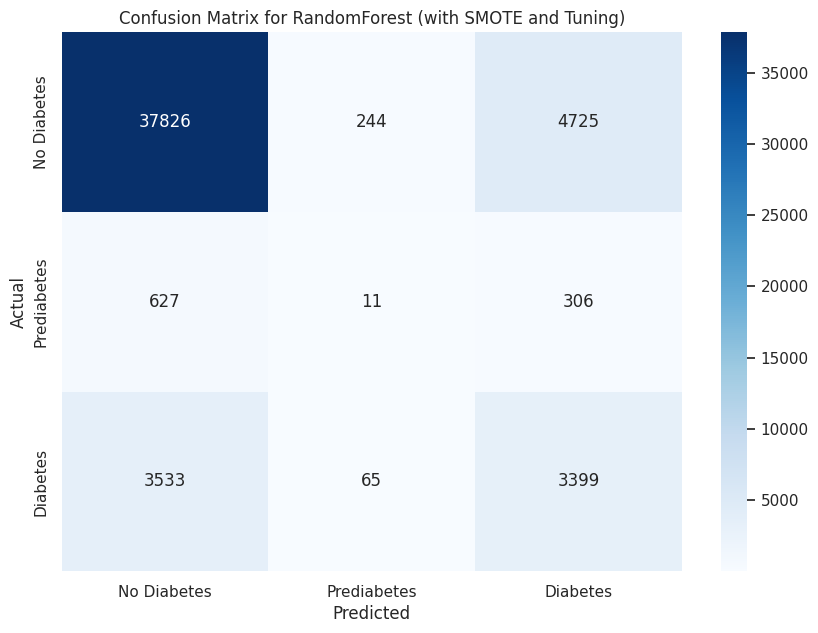

RandomForest Accuracy (with SMOTEENN and Tuning): 0.7152317880794702
Classification Report for RandomForest (SMOTEENN):
               precision    recall  f1-score   support

         0.0       0.94      0.72      0.82     42795
         1.0       0.03      0.03      0.03       944
         2.0       0.32      0.76      0.45      6997

    accuracy                           0.72     50736
   macro avg       0.43      0.51      0.43     50736
weighted avg       0.84      0.72      0.75     50736



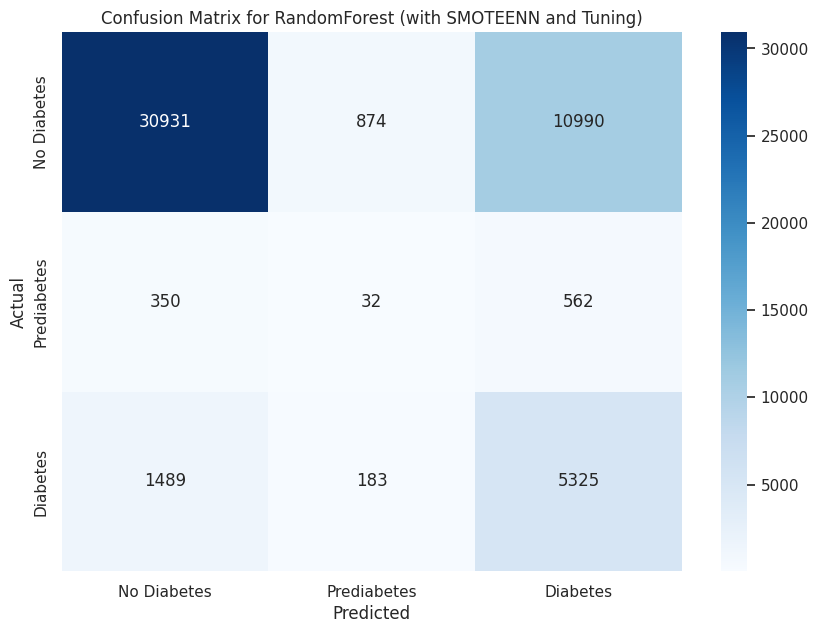

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test set using the tuned RandomForest model (SMOTE)
y_pred_best_rf = best_rf_clf_reduced.predict(X_test)

# Evaluate the tuned RandomForest model (SMOTE)
print("RandomForest Accuracy (with SMOTE and Tuning):", accuracy_score(y_test, y_pred_best_rf))
print("Classification Report for RandomForest (SMOTE):\n", classification_report(y_test, y_pred_best_rf))

# Compute the confusion matrix (SMOTE)
conf_matrix_smote = confusion_matrix(y_test, y_pred_best_rf)

# Plot the confusion matrix (SMOTE)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_smote, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for RandomForest (with SMOTE and Tuning)')
plt.show()

# Predict on the test set using the tuned RandomForest model (SMOTEENN)
y_pred_best_rf_enn = best_rf_clf_reduced_enn.predict(X_test)

# Evaluate the tuned RandomForest model (SMOTEENN)
print("RandomForest Accuracy (with SMOTEENN and Tuning):", accuracy_score(y_test, y_pred_best_rf_enn))
print("Classification Report for RandomForest (SMOTEENN):\n", classification_report(y_test, y_pred_best_rf_enn))

# Compute the confusion matrix (SMOTEENN)
conf_matrix_smoteenn = confusion_matrix(y_test, y_pred_best_rf_enn)

# Plot the confusion matrix (SMOTEENN)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_smoteenn, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for RandomForest (with SMOTEENN and Tuning)')
plt.show()

**Model Evaluation with SMOTE**

RandomForest Accuracy (with SMOTE and Tuning): 81.28%

1. High Precision for "No Diabetes" (0): The model exhibits high precision (0.90), suggesting a minimal false positive rate in predicting the absence of diabetes.

2. Low Performance for "Prediabetes" (1): Both precision and recall scores are underwhelming for this category, indicating challenges in accurately pinpointing prediabetes instances, possibly due to a limited sample size.

3. Moderate Performance for "Diabetes" (2): The model demonstrates moderate precision (0.40) and recall (0.49) for diabetes cases, leaving room for enhancement.

**Confusion Matrix Analysis:**

The majority of predictions align correctly with the "No Diabetes" class.
There are notable misclassifications between instances labeled as "No Diabetes" and those identified as "Diabetes."

**Model Evaluation with SMOTEENN**

RandomForest Accuracy (with SMOTEENN and Tuning): 71.52%

1. Improved Recall for "Diabetes" (2): The recall rate for diabetes cases is improved at 0.76 compared to the SMOTE model, indicating better identification of true instances of diabetes.

2. Lower Performance for "No Diabetes" (0): Precision and recall for this class are lower than the SMOTE model, suggesting more false positives and false negatives.

3. Consistent Low Performance for "Prediabetes" (1): Similar to the SMOTE model, prediabetes remains difficult to predict accurately.

**Confusion Matrix Analysis:**

Upon analyzing the confusion matrix, it is noted that there are more instances of incorrectly classifying cases of no diabetes as diabetes or prediabetes (false negatives). However, there is an increase in correctly identifying cases of diabetes (true positives), indicating an improvement in detection accuracy.

### General Insights

1. **Accuracy vs. Recall Trade-off**:
   - The SMOTE model has higher overall accuracy but lower recall for diabetes.
   - The SMOTEENN model has better recall for diabetes, making it more suitable for scenarios where identifying all potential diabetes cases is crucial, even if it means lower overall accuracy.

2. **Class Imbalance Challenge**:
   - Both models struggle with the "Prediabetes" class due to its small sample size. Further data collection or different modeling approaches may be needed to improve predictions for this class.

3. **Business Implications**:
   - **SMOTE Model**: Higher accuracy can lead to better general performance in identifying non-diabetic individuals, reducing unnecessary interventions.
   - **SMOTEENN Model**: Improved recall for diabetes suggests better early detection, potentially leading to timely intervention and better patient outcomes despite a higher rate of false positives.

4. **Model Selection**:
   - The choice between SMOTE and SMOTEENN depends on the specific needs of the healthcare setting. If the priority is to minimize missed diabetes cases, SMOTEENN might be preferred. For a balanced approach with higher overall accuracy, the SMOTE model could be more suitable.